In [30]:
import numpy as np
import scipy as sp
import math
import time
from numba import njit
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ase
from ase.io.trajectory import *
from scipy.stats import linregress

Codesnippet #1 : initialization of positions

In [31]:
def initialize_positions(N, L):
    """input: total number of atoms (N), box size (L)
    output: positions [(N,3) array]
"""
    #start with zeros
    pos = np.zeros((N,3), float)
    
    #create integer grid locations for cubic lattice
    LocLat = int(N**(1./3.) + 1.)
    #print(LocLat)
    SpacLat = L / LocLat
    #print(SpacLat)    
    
    #create lattice sites
    Lat = SpacLat * np.arange(LocLat, dtype=float) - 0.5*L
    #print(Lat)
    
    #go over x, y, z points
    i = 0
    for x in Lat:
        for y in Lat:
            for z in Lat:
                
                pos[i] = np.array([x,y,z], float)
                
                #random diplacement to help initial CG minimization
                RandDisp = 0.1 * SpacLat * (np.random.rand(3) - 0.5)
                pos[i] = pos[i] + RandDisp
                
                i += 1
                if i >= N:
                    return pos
    return pos

Codesnippet #2 : velocity rescaling

In [32]:
def velocity_rescaler(v, T):
    """input: velocities [(N,3) array] and target temperature (T)
    output: rescaled velocities [(N,3) array]
"""
    # first apply condition for zero net momentum
    v = v - v.mean(axis=0)
    
    #compte the kinetic energy
    kin_energy = 0.5 * np.sum(v * v)
    
    #compute lambda, the rescaling factor 
    lam = np.sqrt(1.5 * len(v) * T / kin_energy)
    v = v * lam
    
    return v

Codesnippet #3 : initialization of velocities

In [33]:
def initialize_velocities(N, T):
    """input: total number of atoms (N) and target tempearture (T)
    output: initial velocities [(N,3) array]
"""
    v = np.random.rand(N, 3)
    v = velocity_rescaler(v, T)

    return v

Codesnippet #4 : calculation of temperature

In [34]:
def calc_temperature(v):
    """input: velocities [(N,3) array] 
    output: instantaneous temperature (T)
"""
    T = np.sum(v * v) / (3. * len(v))
    return T

Calculation of energy

In [35]:
epsilon = 1.0
sigma = 1.0
Rc = 2.5 * sigma
k = 3000.0
r0 = 1.0

def calculate_energy2(positions, L, M): #is not used in final version because the usage of foor loops in combination with numba is faster
    N = positions.shape[0]
    Rij = positions - positions[:, None]    # Create Nx3xN array of distances between atoms in x,y,z directions
    Rij = Rij - L*np.round(Rij/L)           # Take box size into account
    rij = np.linalg.norm(Rij, axis=2)       # Calculate NxN array of actual distances between atoms
    modulo = np.arange(M-1, N-1, M, dtype = int)    # "Cut-off" between molecules
    mask = np.ones((N,N), dtype= bool)      # Create "Mask" array to pick out values from distances 
    mask_modulo = np.ones(N-1, dtype=bool)  # Boolean vector to put on top off mask
    mask_modulo[modulo] = False             # Set values to false that don't fullfill the modulo condition
    mask = mask & (np.diagflat(mask_modulo, 1))     # Merge masks as to only pick distances between bonded atoms
    energy = np.sum(k/2.0 * (rij[mask] - r0) ** 2)  # Sum of energies of bonds between atoms
    mask = np.triu(~mask, 1)                # Ignore lower half of distance matrix
    rij_nobond = rij[mask]                  # pick out all non-bonded interactions
    rij_tmp = rij_nobond[(rij_nobond <= Rc) & (rij_nobond != 0)]    # Filter out distances larger than Rc and = 0
    return energy + np.sum(4*epsilon*((rij_tmp/sigma)**(-12)-(rij_tmp/sigma)**(-6))-4*epsilon*((Rc/sigma)**(-12)-(Rc/sigma)**(-6))) # Sum of potential energy between non-bonded atoms

@njit
def calculate_energy(positions, L, M):
    N = positions.shape[0]
    energy = 0.0
    sigma = 1.0
    Rc = 2.5 * sigma
    def inner_energy_nonbonded(rij):
        u = 0.0
        epsilon = 1.0
        sigma = 1.0
        Rc = 2.5 * sigma
        u = 4*epsilon*((rij/sigma)**(-12)-(rij/sigma)**(-6))-4*epsilon*((Rc/sigma)**(-12)-(Rc/sigma)**(-6))
        return u
    
    def inner_energy_harmonic(rij):
        k = 3000.0
        r0 = 1.0
        u = k/2.0 * (rij - r0) ** 2
        return u

    for j in range (N):
        for i in range (j):
            Rij = np.subtract(positions[i],positions[j])
            Rij += -L*np.rint(Rij/L)
            rij = np.linalg.norm(Rij)
            if j == i+1 and j % M > 0:
                energy += inner_energy_harmonic(rij)
            else:
                if rij <= Rc:
                    energy += inner_energy_nonbonded(rij)
    return energy

calculation of acceleration / forces

In [36]:
@njit
def calculate_forces(positions, L, M):
    N = positions.shape[0]
    epsilon = 1.0
    sigma = 1.0
    r0 = 1.0
    k = 3000.0
    Rc = 2.5 * sigma
    forces = 0.0 * positions.copy()

    def pot_derivative_nonbonded(rij):
        temp = (sigma/rij)**6
        return 4 * epsilon * (6 * temp - 12 * temp ** 2)/rij

    def pot_derivative_harmonic(rij):
        return k*(rij - r0)
    
    for i in range (N):
        for j in range (i+1,N):
            Rij = np.subtract(positions[i],positions[j])
            Rij += -L*np.rint(Rij/L)
            rij = np.linalg.norm(Rij)
            if j == i+1 and j%M >0 and rij!= 0:
                f_rij = pot_derivative_harmonic(rij)
                forces[i] += f_rij/rij*Rij
                forces[j] -= f_rij/rij*Rij
            else:
                if rij <= Rc and rij != 0:
                    f_rij = pot_derivative_nonbonded(rij)
                    forces[i] += f_rij/rij*Rij
                    forces[j] -= f_rij/rij*Rij
    return -forces

calculation of energy and forces

In [37]:
def calculate_en_and_forces(pos, L, M,):
    return calculate_energy(pos, L, M), calculate_forces(pos, L, M)

Optimized Linesearch of Ex5

In [38]:
@njit
def linesearch(pos, M, direction, delta, LStol, MaxLSSteps):
    N = pos.shape[0]
    L = (N/0.8)**(1/3)
    r0 = pos
    r1 = r0 + delta * direction
    r2 = r1 + delta * direction
    u0 = calculate_energy(r0, L, M)
    u1 = calculate_energy(r1, L, M)
    u2 = calculate_energy(r2, L, M)
    
    def gss(lower, upper, M, tol = 1e-05): # golden section search to rmin
        gr = (math.sqrt(5) + 1) / 2
        a = lower
        b = upper
        c = b - (b - a) / gr
        d = a + (b - a) / gr
        while np.linalg.norm(b-a) > tol:
            if calculate_energy(c, L, M ) < calculate_energy(d, L, M ):
                b = d
            else:
                a = c
            c = b - (b - a) / gr
            d = a + (b - a) / gr
            
        return (b+a) / 2

    candidate = gss(r0, r1, M)
    if (u2 > u1 and u1 > u0):
        candidate = gss(r0, r1, M)

        return candidate, calculate_energy(candidate, L, M)
    
    for k in range(MaxLSSteps):

        if (u2 > u1 and u0 > u1):
            candidate = gss(r0, r2, M)
            
            return candidate, calculate_energy(candidate, L, M)
        else:
            r0 = r1
            r1 = r2
            r2 = r1 + delta * direction
            u0 = u1
            u1 = u2
            u2 = calculate_energy(r2, L, M)
            
    return candidate, calculate_energy(candidate, L, M)


Optimized Conjugate Gradient of Ex5

In [39]:
def conju_gra(pos, M, delta=0.001, LStol=10 ** (-8), MaxLSSteps=100000, ECtol=10 ** (-10), MaxCGSteps=100000):
    N = pos.shape[0]
    L = (N/0.8)**(1/3)
    
    prev_fo = calculate_forces(pos, L, M)
    
    prev_dir = prev_fo / (np.sum(abs(prev_fo), axis=1, keepdims=True)) 
    (pos,prev_en) = linesearch(pos, M, prev_dir, delta, LStol, MaxLSSteps)
    
    gamma = np.zeros(N)
    curr_dir = np.zeros([N,3])
    step = 1
    while (step < MaxCGSteps ):
        if step >= 2: 
            prev_fo = curr_fo
            prev_en = curr_en
            prev_dir = curr_dir
        curr_fo = calculate_forces(pos, L, M)
    
        for i in range(N):
            gamma[i] = (np.dot((curr_fo[i] - prev_fo[i]), curr_fo[i])) / (np.dot(prev_fo[i],prev_fo[i]))
            curr_dir[i] = gamma[i] * prev_dir[i,:]
        
        
        curr_dir += curr_fo 
        curr_dir = curr_dir / (np.sum(abs(curr_dir), axis=1, keepdims=True))
        (pos, curr_en) = linesearch(pos, M, curr_dir, delta, LStol, MaxLSSteps)
        if(abs(curr_en - prev_en) < abs(10**(-5)*curr_en)):
            return pos, curr_en
        step += 1  
    return pos, curr_en


Implementation of verlet-integration

In [40]:
@njit
def verlet_integration(pos, vel, acc, L, M, delta_t):
    
    pos = pos + delta_t * vel + 0.5 * delta_t **2 * acc
    vel = vel + 0.5 * delta_t * acc
    
    (pot_energy, acc) = (calculate_energy(pos, L, M), calculate_forces(pos, L, M))
    kin_energy = 0.5 * np.sum(vel**2)
    return pos, vel, acc, pot_energy, kin_energy

Performing molecular dynamics

In [41]:
def md_sim(pos, L, M, T, N):
    vel = initialize_velocities(N,T)
    delta_T = 0.001
    acc = calculate_forces(pos, L, M)
    pot = calculate_energy(pos, L, M)
    kin = 0.5 * np.sum(vel ** 2)
    track_pos_A = []
    track_vel_A = []
    track_kin_A = []
    track_pot_A = []
    pots, kins = [], []
    
    Steps, Rfreq, Wfreq = 10000, 1000, 100
    #Run 6A
    for i in range(1, Steps+1):
        if (i % Rfreq == 0):
            vel = velocity_rescaler(vel, T)

        if (i % Wfreq == 0):
            track_pos_A.append(pos)
            track_vel_A.append(vel)
            track_kin_A.append(kin)
            track_pot_A.append(pot)
        
        pots.append(pot)
        kins.append(kin)
        

        (pos, vel, acc, pot, kin) = verlet_integration(pos, vel, acc, L, M, delta_T)
    
    tots = pots + kins
    
    
    pot_var = np.var(pots)
    kin_var = np.var(kins)
    tot_var = np.var(tots)
    
    print("Variance of the potenatial energy for the first phase of simulation: \t", pot_var)
    print("Variance of the kinetic energy for the first phase of simulation: \t", kin_var)
    print("Variance of total energy for the first phase of simulation: \t", tot_var)
    
    track_pos_B = []
    track_vel_B = []
    track_kin_B = []
    track_pot_B = []

#Run 6B
    pots, kins = [], []
    for i in range(1, Steps+1):
        if (i % Rfreq == 0):
            vel = velocity_rescaler(vel, T)

        if (i % Wfreq == 0):
            track_pos_B.append(pos)
            track_vel_B.append(vel)
            track_kin_B.append(kin)
            track_pot_B.append(pot)

        pots.append(pot)
        kins.append(kin)

        (pos, vel, acc, pot, kin) = verlet_integration(pos, vel, acc, L, M, delta_T)

    avrg_pot = np.sum(pots) / Steps
    avrg_kin = np.sum(kins) / Steps
    avrg_en = avrg_pot + avrg_kin

    inst_pot = pot
    inst_kin = avrg_en - inst_pot
    inst_T = (2 * inst_kin) / (3 * len(vel))
    
    tots = pots + kins
    
    
    pot_var = np.sum((pots - avrg_pot) ** 2) / (len(pots) - 1)
    kin_var = np.sum((kins - avrg_kin) ** 2) / (len(kins) - 1)
    tot_var = np.sum((tots - avrg_en) ** 2) / (len(tots) - 1)
    
    print("Variance of the potenatial energy for the second phase of simulation: \t", pot_var)
    print("Variance of the kinetic energy for the second phase of simulation: \t", kin_var)
    print("Variance of total energy for the second phase of simulation: \t", tot_var)

    track_pos_B_add = []
    track_vel_B_add = []
    track_kin_B_add = []
    track_pot_B_add = []

    EPS = 10**(-8)
    index = 1
    while (abs(kin - inst_kin) > abs(EPS*kin)):
        index += 1
        vel = velocity_rescaler(vel, inst_T)
        kin = 0.5 * np.sum(vel ** 2)

        if (index % Wfreq == 0):
            track_pos_B_add.append(pos)
            track_vel_B_add.append(vel)
            track_kin_B_add.append(kin)
            track_pot_B_add.append(pot)

    posRef = pos.copy()

#Run 6D
    track_pos_D = []
    track_vel_D = []
    track_kin_D = []
    track_pot_D = []
    track_MSD = []
    
    pots, kins = [], []

    Steps = 100000
    for i in range(1, Steps+1):
        if (i % Wfreq == 0):
            track_pos_D.append(pos)
            track_vel_D.append(vel)
            track_kin_D.append(kin)
            track_pot_D.append(pot)
            track_MSD.append(np.sum(np.linalg.norm(pos - posRef, axis=1) ** 2)/N)
        pots.append(pot)
        kins.append(kin)
        
        (pos, vel, acc, pot, kin) = verlet_integration(pos, vel, acc, L, M, delta_T)
        
    tots = pots + kins
    pot_mean = np.mean(pots)
    kin_mean = np.mean(kins)
    tot_mean = np.mean(tots)
    
    pot_var = np.sum((pots - pot_mean) ** 2) / (len(pots) - 1)
    kin_var = np.sum((kins - kin_mean) ** 2) / (len(kins) - 1)
    tot_var = np.sum((tots - tot_mean) ** 2) / (len(tots) - 1)
    
    print("Variance of the potenatial energy for the final phase of simulation: \t", pot_var)
    print("Variance of the kinetic energy for the final phase of simulation: \t", kin_var)
    print("Variance of total energy for the final phase of simulation: \t", tot_var)   
    
    return(track_pos_D, track_MSD, track_kin_D, track_pot_D, track_kin_A, track_kin_B, track_pot_A, track_pot_B)


Execution of the MD-Simulation for different M + Bonus task

In [51]:
N = 240
L = (N/0.8)**(1/3)
pos = initialize_positions(N,L)
M = 4
T = 1.5
print("T = 1.5 and M = 4")
pos4, energy4 = conju_gra(pos, M)
pos_4, msd_4, kind_4, potd_4, kina_4, kinb_4, pota_4, potb_4 = md_sim(pos4, L, M, T, N)
print("done")
M = 8
pos8, energy8 = conju_gra(pos, M)
print("T = 1.5 and M = 8")
pos_8, msd_8, kind_8, potd_8, kina_8, kinb_8, pota_8, potb_8 = md_sim(pos8, L, M, T, N)
print("done")
M = 16
pos16, energy16 = conju_gra(pos, M)
print("T = 1.5 and M = 16")
pos_16, msd_16, kind_16, potd_16, kina_16, kinb_16, pota_16, potb_16 = md_sim(pos16, L, M, T, N)
print("done")

# Bonus:
M = 8
T = 1.0
print("T = 1.0 and M = 8")
pos_8_1, msd_8_1, kind_8_1, potd_8_1, kina_8_1, kinb_8_1, pota_8_1, potb_8_1 = md_sim(pos8, L, M, T, N)
print("done")
T = 2.0
print("T = 2.0 and M = 8")
pos_8_2, msd_8_2, kind_8_2, potd_8_2, kina_8_2, kinb_8_2, pota_8_2, potb_8_2 = md_sim(pos8, L, M, T, N)
print("done")



T = 1.5 and M = 4
Variance of the potenatial energy for the first phase of simulation: 	 10877.437929306188
Variance of the kinetic energy for the first phase of simulation: 	 5330.514584564781
Variance of total energy for the first phase of simulation: 	 293530.5669210919
Variance of the potenatial energy for the second phase of simulation: 	 1417.2441837954336
Variance of the kinetic energy for the second phase of simulation: 	 380.3379340774787
Variance of total energy for the second phase of simulation: 	 270645.104661689
Variance of the potenatial energy for the final phase of simulation: 	 1165.960132197834
Variance of the kinetic energy for the final phase of simulation: 	 291.41769530735485
Variance of total energy for the final phase of simulation: 	 268917.81570507074
done
T = 1.5 and M = 8
Variance of the potenatial energy for the first phase of simulation: 	 11309.229206166272
Variance of the kinetic energy for the first phase of simulation: 	 5241.076053496999
Variance of 

SystemError: CPUDispatcher(<function verlet_integration at 0x0000025390D94280>) returned a result with an error set

Trajectory for M = 4 and T = 1.5

In [44]:
traj = Trajectory('polymer4.traj', 'w')
i=0
fac=1.0

while i < len(pos_4):
    nano = ase.Atoms('C240', pos_4[i]*fac)
    i+=1
    traj.write(nano)

ValueError: Array "positions" has wrong length: 16 != 240.

Trajectory for M = 8 and T = 1.5

In [ ]:
traj = Trajectory('polymer8.traj', 'w')
i=0
fac=1.0

while i < len(pos_8):
    nano = ase.Atoms('C240', pos_8[i]*fac)
    i+=1
    traj.write(nano)

Trajectory for M = 16 and T = 1.5

In [ ]:
traj = Trajectory('polymer16.traj', 'w')
i=0
fac=1.0

while i < len(pos_16):
    nano = ase.Atoms('C240', pos_16[i]*fac)
    i+=1
    traj.write(nano)

Trajectory for M = 8 and T = 1.0

In [ ]:
traj = Trajectory('polymer8_1.traj', 'w')
i=0
fac=1.0

while i < len(pos_8_1):
    nano = ase.Atoms('C240', pos_8_1[i]*fac)
    i+=1
    traj.write(nano)

Trajectory for M = 8 and T = 2.0

In [ ]:
traj = Trajectory('polymer8_2.traj', 'w')
i=0
fac=1.0

while i < len(pos_8_2):
    nano = ase.Atoms('C240', pos_8_2[i]*fac)
    i+=1
    traj.write(nano)

Plot of Mean square displacement over time

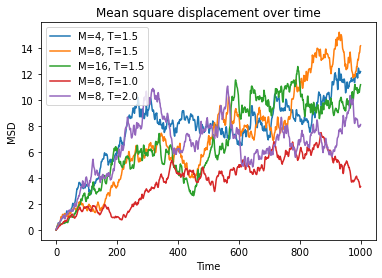

In [45]:

plt.figure()
plt.plot(msd_4, label='M=4, T=1.5')
plt.plot(msd_8, label='M=8, T=1.5')
plt.plot(msd_16, label='M=16, T=1.5')
plt.plot(msd_8_1, label='M=8, T=1.0')
plt.plot(msd_8_2, label='M=8, T=2.0')
plt.xlabel('Time')
plt.ylabel('MSD')
plt.title('Mean square displacement over time')
plt.legend()

Calculation of Diffusivity

In [46]:
lagtimes = np.arange(1000)*0.1
all_msd = [msd_4, msd_8, msd_16, msd_8_1, msd_8_2]
all_D = []
for i in range(len(all_msd)):
    linear_model = linregress(lagtimes, all_msd[i])
    slope = linear_model.slope
    error = linear_model.rvalue
    D = slope * 1/(6)
    all_D.append(D)

print("For T = 1.5 and M = 4: \t D = ", all_D[0])
print("For T = 1.5 and M = 8: \t D = ", all_D[1])
print("For T = 1.5 and M = 16: \t D = ", all_D[2])
print("For T = 1.0 and M = 8: \t D = ", all_D[3])
print("For T = 2.0 and M = 8: \t D = ", all_D[4])






For T = 1.5 and M = 4: 	 D =  0.012196014354074783
For T = 1.5 and M = 8: 	 D =  0.020890467703813736
For T = 1.5 and M = 16: 	 D =  0.016214860740599867
For T = 1.0 and M = 8: 	 D =  0.009176862573537987
For T = 2.0 and M = 8: 	 D =  0.006342360621125063


TypeError: only size-1 arrays can be converted to Python scalars

Plot of total energy over time 

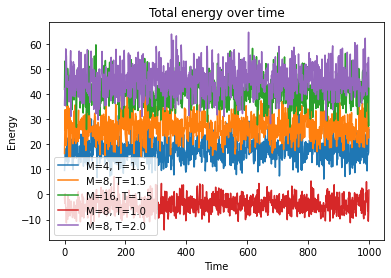

In [47]:
tot_en_4 = np.asarray(kind_4) + np.asarray(potd_4)
tot_en_8 = np.asarray(kind_8) + np.asarray(potd_8)
tot_en_16 = np.asarray(kind_16) + np.asarray(potd_16)
tot_en_8_1 = np.asarray(kind_8_1) + np.asarray(potd_8_1)
tot_en_8_2 = np.asarray(kind_8_2) + np.asarray(potd_8_2)

plt.figure()
plt.plot(tot_en_4, label='M=4, T=1.5')
plt.plot(tot_en_8, label='M=8, T=1.5')
plt.plot(tot_en_16, label='M=16, T=1.5')
plt.plot(tot_en_8_1, label='M=8, T=1.0')
plt.plot(tot_en_8_2, label='M=8, T=2.0')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Total energy over time')
plt.legend()


Plot of potential energy over time

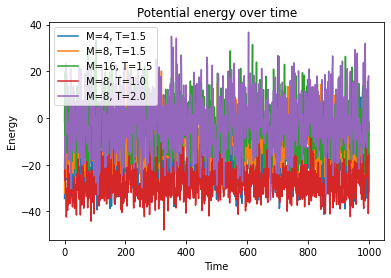

In [48]:
plt.figure()
plt.plot(potd_4, label='M=4, T=1.5')
plt.plot(potd_8, label='M=8, T=1.5')
plt.plot(potd_16, label='M=16, T=1.5')
plt.plot(potd_8_1, label='M=8, T=1.0')
plt.plot(potd_8_2, label='M=8, T=2.0')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Potential energy over time')
plt.legend()


Plot of kinetic energy over time

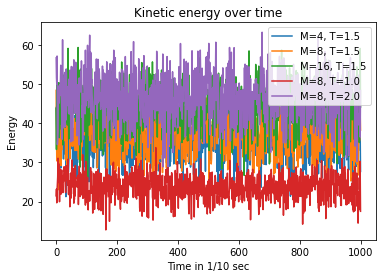

In [49]:
plt.figure()
plt.plot(kind_4, label='M=4, T=1.5')
plt.plot(kind_8, label='M=8, T=1.5')
plt.plot(kind_16, label='M=16, T=1.5')
plt.plot(kind_8_1, label='M=8, T=1.0')
plt.plot(kind_8_2, label='M=8, T=2.0')
plt.xlabel('Time in 1/10 sec')
plt.ylabel('Energy')
plt.title('Kinetic energy over time')
plt.legend()



Visualization of the final positions of the atoms for M = 8 

In [50]:
x = pos_8_2[999][:, 0]
y = pos_8_2[999][:, 1]
z = pos_8_2[999][:, 2]

fig = go.Figure()
M = 8
for i in range(int(N/M)):
    fig.add_trace(go.Scatter3d(x=x[M*i:M*(i+1)],y=y[M*i:M*(i+1)],z=z[M*i:M*(i+1)],mode='lines+markers'))

fig.show()